In [1]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pathlib import Path
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.models.resnet import Bottleneck, ResNet
from timm.models.vision_transformer import VisionTransformer
import matplotlib.pyplot as plt

In [3]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, data_df, transform=None):
        self.data_dir = data_dir
        self.labels_df = data_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.data_dir / f"img_{self.labels_df.iloc[idx]['id']}.png"
        image = Image.open(img_path).convert('RGB')
        label = self.labels_df.iloc[idx]['malignant']

        if self.transform:
            image = self.transform(image)
        sample = {'image': image,
                  'label': label,
                  'id': self.labels_df.iloc[idx]['id']}
        return sample

In [5]:
def show_imgs(ims, captions=None):
    fig, ax = plt.subplots(nrows=1, ncols=len(ims), figsize=(10, 5))
    for i in range(len(ims)):
        ax[i].imshow(ims[i])
        ax[i].axis('off')
        if captions is not None:
          ax[i].set_title(captions[i], fontweight="bold")

In [6]:
def get_pretrained_url(key):
    URL_PREFIX = "https://github.com/lunit-io/benchmark-ssl-pathology/releases/download/pretrained-weights"
    model_zoo_registry = {
        "DINO_p16": "dino_vit_small_patch16_ep200.torch",
        "DINO_p8": "dino_vit_small_patch8_ep200.torch",
    }
    pretrained_url = f"{URL_PREFIX}/{model_zoo_registry.get(key)}"
    return pretrained_url


def vit_small(pretrained, progress, key, **kwargs):
    patch_size = kwargs.get("patch_size", 16)
    model = VisionTransformer(
        img_size=224, patch_size=patch_size, embed_dim=384, num_heads=6, num_classes=0
    )
    if pretrained:
        pretrained_url = get_pretrained_url(key)
        verbose = model.load_state_dict(
            torch.hub.load_state_dict_from_url(pretrained_url, progress=progress)
        )
        print(verbose)
    return model

In [7]:
# Set random seed for reproducibility
torch.manual_seed(2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
# read in the data
data_dir = Path("/content/data")

In [8]:
# unzip data
! unzip -q /content/data/oxml-carinoma-classification.zip -d /content/data/

In [9]:
labels_file = data_dir / 'labels.csv'
data_df = pd.read_csv(labels_file)

# Transform the class colum to positive values
data_df['malignant'] = data_df['malignant'] + 1
data_df

,id,malignant
0,441,0
1,33284,0
2,38771,2
3,46784,0
4,57613,0
...,...,...
57,918503,0
58,931650,0
59,955514,1
60,965412,0


In [10]:
# see how many we ahve from each class
n_healthy = (data_df['malignant'] == 0).sum() # class 0
n_benign = (data_df['malignant'] == 1).sum() # class 1
n_malign = (data_df['malignant'] == 2).sum() # class 2
data_df['malignant'].value_counts()

0    36
1    14
2    12
Name: malignant, dtype: int64

# Load data

In [20]:
# Define any image transformations if needed
# transform = torchvision.transforms.Compose([...])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.2), # augment the data
    transforms.RandomVerticalFlip(0.2),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    # Rescale pixel to [-1, 1] values.
    # The first tuple (0.5, 0.5, 0.5) is the mean for all three
    # channels and the second (0.5, 0.5, 0.5) is the standard
    # deviation for all three channels.
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [21]:
# Create the custom dataset
dataset = CustomDataset(data_dir, data_df, transform)

In [22]:
# Create the data loader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [23]:
sample = next(iter(dataloader))
print(f"Len dataloader: {len(dataloader)}")
print(f"Image shape: {sample['image'].shape} Labels shape: {sample['label'].shape}")

Len dataloader: 4
Image shape: torch.Size([16, 3, 224, 224]) Labels shape: torch.Size([16])


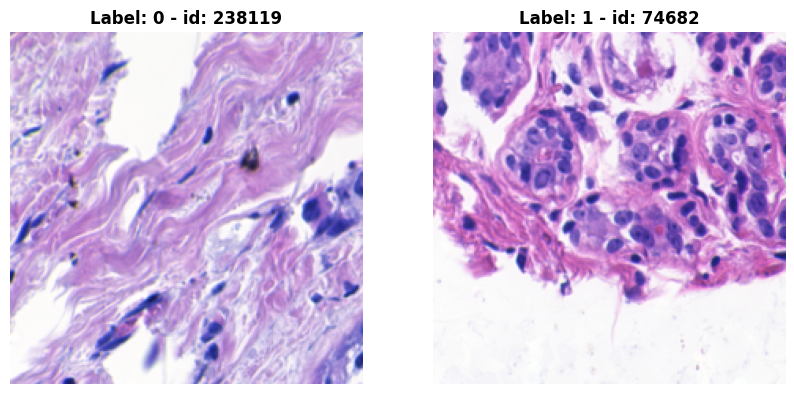

In [24]:
show_imgs([sample["image"][1].permute(1, 2, 0), sample["image"][2].permute(1, 2, 0)],
          captions=[f"Label: {sample['label'][1]} - id: {sample['id'][1]}",
                    f"Label: {sample['label'][2]} - id: {sample['id'][2]}"])

# Get a pre-trained model
Here I will use the models [from](https://github.com/lunit-io/benchmark-ssl-pathology)

In [26]:
# add Fully connected linear layer
class Resnet_fc(nn.Module):
  def __init__(self, pre_trained_model):
    super(Resnet_fc, self).__init__()
    n_classes = 3
    self.model = pre_trained_model
    #self.fc = nn.Sequential(nn.Linear(2048*7, 7),
                            #nn.ReLU(),
                            #nn.Linear(7, 3))
    self.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(384, n_classes))

  def forward(self, x):
    x = self.model(x)
    x = self.fc(x)
    return x

In [25]:
# Size of the last layer from the pretrained model
bla = pre_trained_model(sample["image"].to(device))
bla.shape

torch.Size([16, 384])

In [29]:
# Create a last fully connected layer to match the number of classes
# Note: the number of of nodes was determined by looking at the network

num_classes = 3
pre_trained_model = vit_small(pretrained=True, progress=False, key="DINO_p16", patch_size=16)

# Freeze the parameters in the pre-trained network
for param in pre_trained_model.parameters():
    param.requires_grad = False

# Add the fully connected layer that we want to optmize
model = Resnet_fc(pre_trained_model)
model.to(device)


<All keys matched successfully>


Resnet_fc(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
  

In [30]:
# note that only the last parameters will be optimized
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# Define the loss function
# use weights to balance out the imbalanced classification
weights = [1/n_healthy, 1/n_benign, 1/n_malign]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-6, patience=50)

In [31]:
num_epochs = 200
epoch_loss_list = []
epoch_lr = []
model.train()
for epoch in range(num_epochs):
  running_loss = 0.0
  print('-' * 10)
  for inputs in dataloader:
    images = inputs["image"].to(device)
    labels = inputs["label"].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    loss.backward()
    optimizer.step()
    scheduler.step(loss)

  epoch_loss = running_loss / len(dataloader)
  epoch_loss_list.append(epoch_loss)
  epoch_lr.append(get_lr(optimizer))
  print(f"Epoch {epoch}/{num_epochs} - Loss: {epoch_loss:.4f}")


----------
Epoch 0/200 - Loss: 1.1629
----------
Epoch 1/200 - Loss: 0.9700
----------
Epoch 2/200 - Loss: 1.6675
----------
Epoch 3/200 - Loss: 0.5886
----------
Epoch 4/200 - Loss: 0.2706
----------
Epoch 5/200 - Loss: 0.5495
----------
Epoch 6/200 - Loss: 0.3824
----------
Epoch 7/200 - Loss: 0.2467
----------
Epoch 8/200 - Loss: 0.2077
----------
Epoch 9/200 - Loss: 0.0030
----------
Epoch 10/200 - Loss: 0.5628
----------
Epoch 11/200 - Loss: 0.2835
----------
Epoch 12/200 - Loss: 0.3002
----------
Epoch 13/200 - Loss: 0.0047
----------
Epoch 14/200 - Loss: 0.1480
----------
Epoch 15/200 - Loss: 0.0085
----------
Epoch 16/200 - Loss: 0.0191
----------
Epoch 17/200 - Loss: 0.0509
----------
Epoch 18/200 - Loss: 0.0008
----------
Epoch 19/200 - Loss: 0.0039
----------
Epoch 20/200 - Loss: 0.0232
----------
Epoch 21/200 - Loss: 0.0002
----------
Epoch 22/200 - Loss: 0.0023
----------
Epoch 23/200 - Loss: 0.0015
----------
Epoch 24/200 - Loss: 0.0024
----------
Epoch 25/200 - Loss: 0.0

Text(0, 0.5, 'Loss')

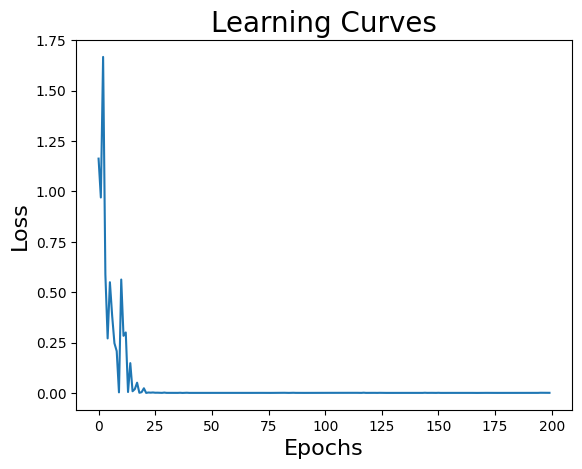

In [32]:
plt.plot(epoch_loss_list)
plt.title("Learning Curves", fontsize=20)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

Text(0, 0.5, 'Loss')

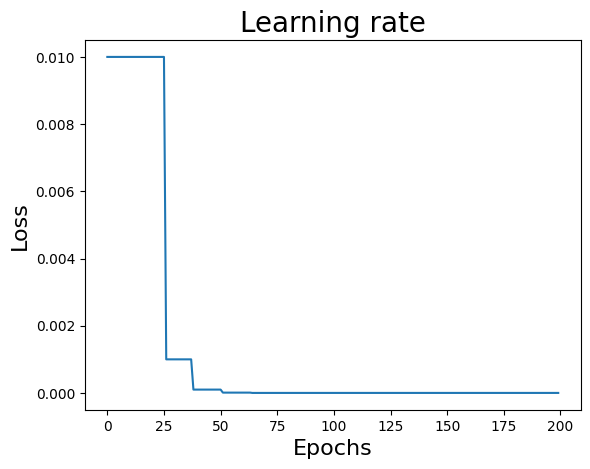

In [33]:
plt.plot(epoch_lr)
plt.title("Learning rate", fontsize=20)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

# Get the test labels

In [34]:
output = {}

output_df = pd.DataFrame(columns=['id', 'malignant'])
images_files = data_dir.glob("*.png")
# remove files that we have labels for
training_ids = data_df['id'].to_list()
test_ids = []
for idx, image_file in enumerate(images_files):
  id = int(image_file.stem.split('_')[1])
  if id not in training_ids:
    test_ids.append(id)

    # Load image
    image = Image.open(image_file).convert('RGB')
    data = transform(image).to(device)
    # Add Batch dimension
    data = torch.unsqueeze(data, 0)

    # pass image to the model
    label = torch.argmax(model(data)).cpu().detach().numpy() - 1

    output_df.loc[idx] = [id, label]

print(f'Number of unlabelled images: {len(test_ids)}')

Number of unlabelled images: 124


In [35]:
output_df

,id,malignant
1,467694,0
2,812227,-1
3,67212,-1
5,346084,-1
6,97549,-1
...,...,...
178,791719,0
180,74995,-1
183,957521,0
184,125877,-1


In [36]:
output_df['malignant'].value_counts()

-1    54
 0    38
 1    32
Name: malignant, dtype: int64

In [46]:
output_df[output_df['malignant'] >= 0]['id'].to_list()

[467694,
 802239,
 367735,
 868794,
 819075,
 697673,
 39157,
 976505,
 93671,
 37944,
 314793,
 930969,
 257699,
 5042,
 243243,
 912471,
 777273,
 901399,
 94101,
 801999,
 118847,
 395881,
 422756,
 322111,
 333275,
 240314,
 557633,
 433126,
 587220,
 367119,
 846399,
 841570,
 534691,
 156941,
 186315,
 175012,
 714933,
 376611,
 471984,
 49868,
 505739,
 757632,
 255427,
 945970,
 732824,
 186728,
 931110,
 295118,
 646642,
 67507,
 879144,
 792150,
 310272,
 741219,
 291326,
 248239,
 713071,
 303169,
 739490,
 133778,
 959476,
 900056,
 139077,
 136044,
 655750,
 407269,
 586391,
 229280,
 791719,
 957521]

In [47]:
# save output
output_df.to_csv(data_dir / 'predictions.csv', index=False)

In [38]:
second_pred = pd.read_csv(data_dir / 'second_submission_predictions.csv')
print(second_pred['malignant'].value_counts())
second_pred[second_pred['malignant'] >= 0]


-1    72
 0    35
 1    17
Name: malignant, dtype: int64


,id,malignant
2,35946,1
6,49868,1
8,67212,0
10,74995,0
11,76700,0
13,93671,1
19,125877,0
21,133962,0
22,136044,0
23,139077,1


In [40]:
# acc: 0.61
third_pred = pd.read_csv(data_dir / 'first_submission_predictions.csv')
third_pred[third_pred['malignant'] >= 0]

,id,malignant
9,367735,0
38,837363,0
73,945970,0
